#MRI Brain Tumor Classification Model

---



---



###Importing needed libraries

In [ ]:
# Importing necessary libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from kagglehub import dataset_download

###Importing the Kaggle dataset for the MRI model

In [ ]:
# Defining data path
path = dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")
MRI_path = path + 'versions/1/Dataset/Brain Tumor MRI images'
img_height, img_width = 224, 224  # Image dimensions
batch_size = 32  # Batch size

print(MRI_path)

100%|██████████| 361M/361M [00:15<00:00, 24.9MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1versions/1/Dataset/Brain Tumor MRI images


In [ ]:
import os
import shutil
import random
# Original directory where 'Healthy' and 'Tumor' directories are located
base_dir = os.path.join(path, 'Dataset', 'Brain Tumor MRI images')

# Creating folders for train_val and test
train_val_dir = os.path.join(base_dir, "train_val")
test_dir      = os.path.join(base_dir, "test")

test_ratio = 0.3  # 30% test set

# For each class
for class_name in ["Healthy", "Tumor"]:
    class_dir = os.path.join(base_dir, class_name)

    # Creating 'Healthy' and 'Tumor' directories inside 'train_val' and 'test' directories
    train_val_class_dir = os.path.join(train_val_dir, class_name)
    test_class_dir      = os.path.join(test_dir,      class_name)

    os.makedirs(train_val_class_dir, exist_ok=True)
    os.makedirs(test_class_dir,      exist_ok=True)

    # List every image in the whole directory
    all_images = os.listdir(class_dir)

    # Shuffle them
    random.shuffle(all_images)

    # Calculate how many will go to the test directory
    test_size = int(len(all_images) * test_ratio)

    # Divide the list
    test_images      = all_images[:test_size]
    train_val_images = all_images[test_size:]

    # Move the images to the respective directories
    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_class_dir, img)
        shutil.move(src, dst)

    for img in train_val_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_val_class_dir, img)
        shutil.move(src, dst)


### Augmentation and preprocessing

In [ ]:
# Generator including augmentations for the training and validation sets
train_val_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,      # 20% for the validation set
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator without augmentations for the test set
test_data_gen = ImageDataGenerator(rescale=1./255)

# Loading training set
train_data = train_val_data_gen.flow_from_directory(
    directory=train_val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',   # 80%
    seed=42,
    shuffle=True
)

# Loading validation set
val_data = train_val_data_gen.flow_from_directory(
    directory=train_val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation', # 20%
    seed=42,
    shuffle=True
)

# Loading test set
test_data = test_data_gen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Usually done like this to evaluate with order
)


Found 2800 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


###Function to visualize the images


---------------------------------------Test data images (all healthy because it's not shuffled)---------------------------------------



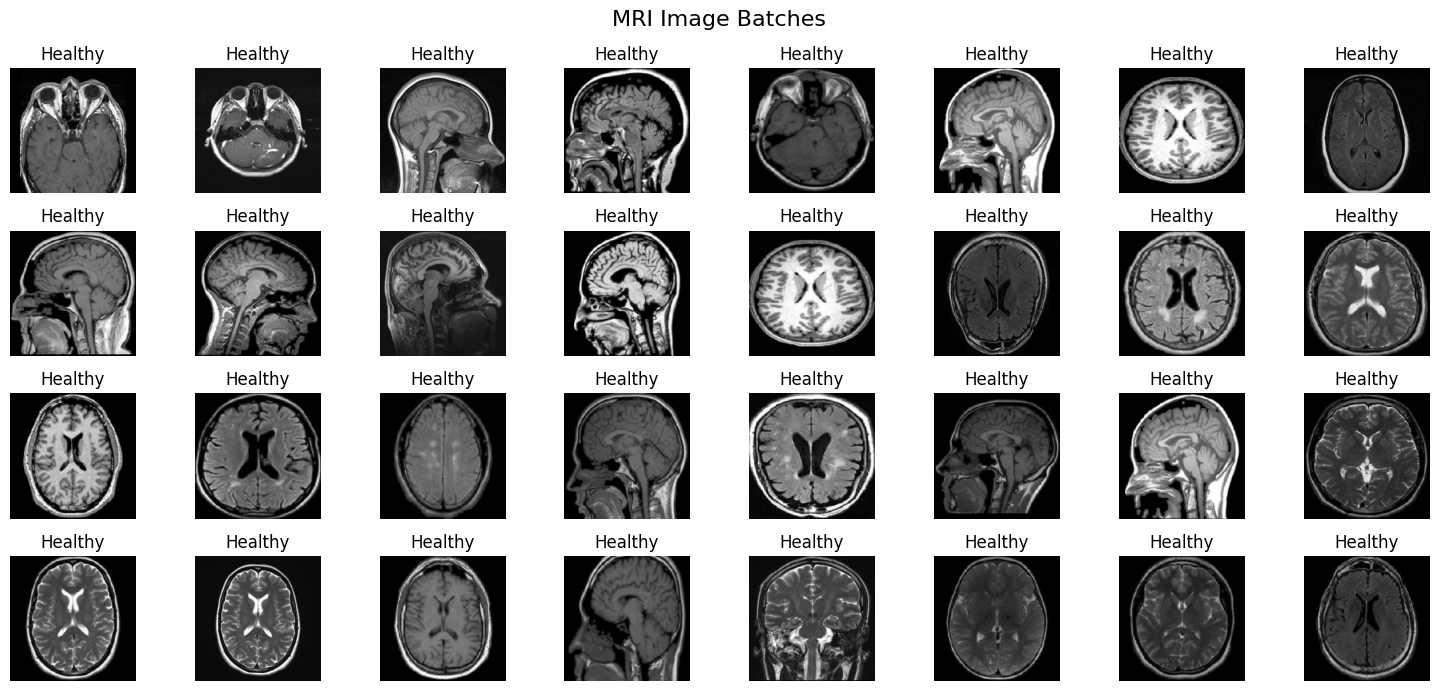


----------------------------------------------Train data images (shuffled and augmented)----------------------------------------------



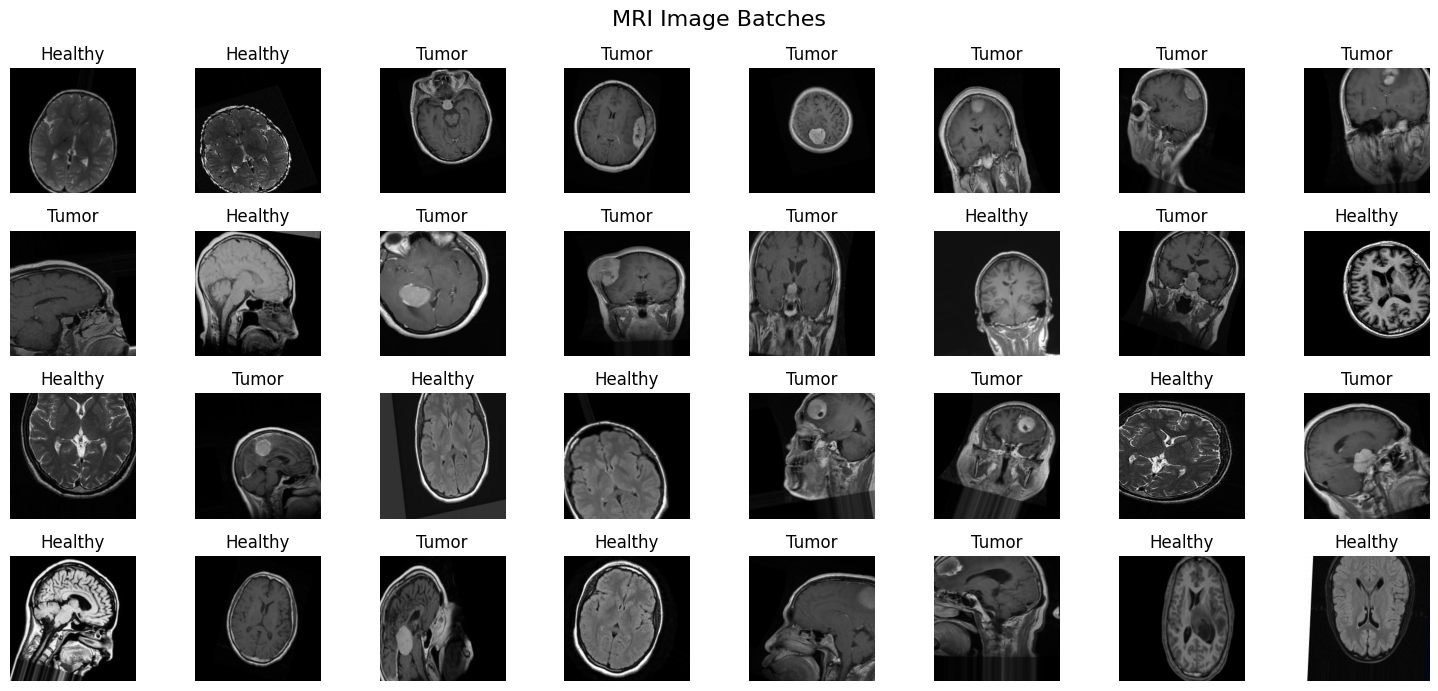

In [ ]:
# Function to visualize image batches
def show_batches(data, n=32):
    images, labels = next(iter(data))
    plt.figure(figsize=(15, 7))
    # Include a title
    plt.suptitle('MRI Image Batches', fontsize=16)
    for i in range(n):
        # Leave some separation between the images from the top and from the bottom
        plt.subplot(4, 8, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        # The title will be Healthy if it's 0 and Tumor if it's 1
        plt.title(f'{"Healthy" if labels[i][0] == 1 else "Tumor"}')
    plt.tight_layout()
    plt.show()

# Visualize a batch from the test and train_data
print("\n---------------------------------------Test data images (all healthy because it's not shuffled)---------------------------------------\n")
show_batches(test_data)
print('\n----------------------------------------------Train data images (shuffled and augmented)----------------------------------------------\n')
show_batches(train_data)

###Creating the Neural Network

In [ ]:
from keras.layers import Resizing, Rescaling

# Defining the model
model = models.Sequential([
    # Standardizes the input size for subsequent layers
    layers.Resizing(224, 224, input_shape=(None, None, 3)),
    # 3x3 kernel with 'relu' activation to extract basic features (edges, corners).
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    # Reduces the spatial size of the feature maps
    layers.MaxPooling2D((2, 2)),
    # Feature extraction at a higher level, learning more complex patterns
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    # Softmax will help to give probabilites to each image over the possible classes (Healthy or Tumor)
    layers.Dense(train_data.num_classes, activation='softmax')
])

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

###Training the model and plotting the training history

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 62s 589ms/step - accuracy: 0.5796 - loss: 0.7307 - val_accuracy: 0.7114 - val_loss: 0.5426
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 65s 466ms/step - accuracy: 0.7932 - loss: 0.4598 - val_accuracy: 0.7543 - val_loss: 0.5641
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 45s 484ms/step - accuracy: 0.8315 - loss: 0.4023 - val_accuracy: 0.8014 - val_loss: 0.4523
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 44s 464ms/step - accuracy: 0.8440 - loss: 0.3724 - val_accuracy: 0.8214 - val_loss: 0.4254
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 463ms/step - accuracy: 0.8514 - loss: 0.3535 - val_accuracy: 0.8014 - val_loss: 0.4269
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 484ms/step - accuracy: 0.8759 - loss: 0.3269 - val_accuracy: 0.8257 - val_loss: 0.3805
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 499ms/step - accuracy: 0.8620 - loss: 0.3198 - val_accuracy: 0.7914 - val_loss: 0.4834
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 465ms/step - accuracy: 0.8775 - loss: 0.3152 - val_accu

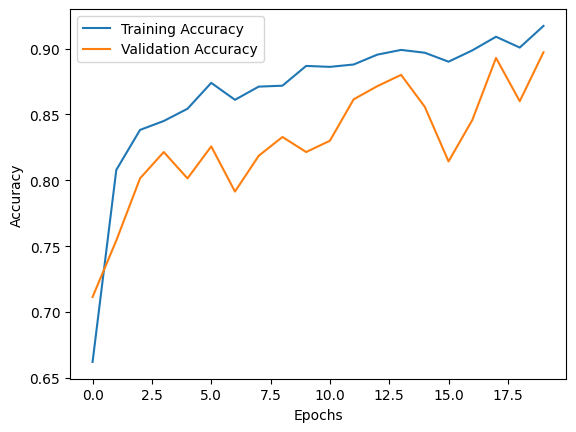

In [ ]:
# Training the model
epochs = 20
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs
)

# Plotting the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

###Evaluating the model

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Save the model
model.save('initial_model.keras')


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8983 - loss: 0.2464
Test Accuracy: 90.53%


### Confusion matrix for the initial model

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step


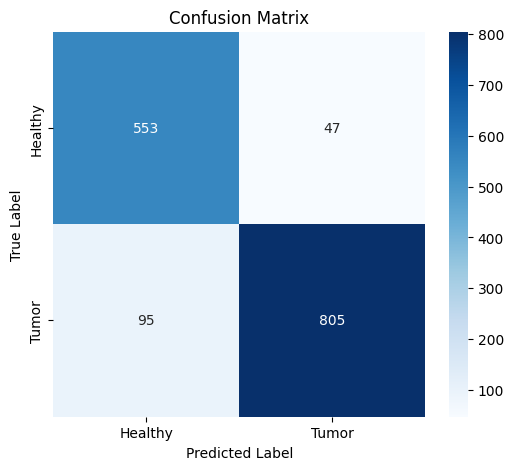

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Names of the classes
class_names = ["Healthy", "Tumor"]

# Start from the beggining of the test set to avoid errors
test_data.reset()

# We calculate the number of steps to make to predict the whole test set
steps = math.ceil(test_data.samples / test_data.batch_size)

# We make predictions for every image of the test set
predictions = model.predict(test_data, steps=steps)

# We convert this prections to class indexes (0 = Healthy, 1 = Tumor)
y_pred = np.argmax(predictions, axis=1)

# Labels are 0 and 1 because of the one-hot encoding
y_true = test_data.classes

# Calculation of the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Show the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


###Hyperparameter tuning

In [ ]:
# Hyperparameter tuning with Keras Tuner
!pip install keras-tuner
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Resizing(224, 224, input_shape=(None, None, 3))),
    model.add(layers.Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
                            (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(layers.Conv2D(hp.Int(f'conv_{i+2}_filters', min_value=32, max_value=128, step=32),
                                (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(train_data.num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.1 MB/s eta 0:00:00


###Running the tuner

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='brain_tumor_classification'
)

tuner.search(train_data, validation_data=val_data, epochs=6)

# Getting the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

Trial 15 Complete [00h 06m 22s]
val_accuracy: 0.8114285469055176

Best val_accuracy So Far: 0.8342857360839844
Total elapsed time: 01h 37m 19s
Best hyperparameters: {'conv_1_filters': 64, 'num_conv_layers': 3, 'conv_2_filters': 64, 'dense_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'conv_3_filters': 32, 'conv_4_filters': 64}


###Training the best model

In [ ]:
# Retrain the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

best_model.fit(train_data, validation_data=val_data, epochs=25)

# Save the best model
best_model.save('best_brain_tumor_classifier.keras')

Epoch 1/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 531ms/step - accuracy: 0.5930 - loss: 0.6761 - val_accuracy: 0.7514 - val_loss: 0.5021
Epoch 2/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 78s 498ms/step - accuracy: 0.8107 - loss: 0.4461 - val_accuracy: 0.7129 - val_loss: 0.5864
Epoch 3/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 470ms/step - accuracy: 0.8242 - loss: 0.3927 - val_accuracy: 0.7829 - val_loss: 0.4782
Epoch 4/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 47s 510ms/step - accuracy: 0.8376 - loss: 0.3882 - val_accuracy: 0.7329 - val_loss: 0.6947
Epoch 5/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 80s 490ms/step - accuracy: 0.8592 - loss: 0.3599 - val_accuracy: 0.7571 - val_loss: 0.5240
Epoch 6/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 483ms/step - accuracy: 0.8516 - loss: 0.3583 - val_accuracy: 0.8571 - val_loss: 0.3570
Epoch 7/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 82s 493ms/step - accuracy: 0.8741 - loss: 0.3123 - val_accuracy: 0.8629 - val_loss: 0.3617
Epoch 8/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 81s 467ms/step - accuracy: 0.8926 - loss: 0.2887 - val_accu

###Evaluating the final model

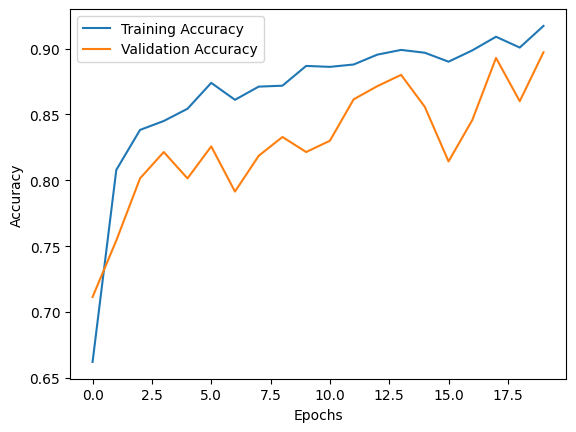

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.8928 - loss: 0.2558
Test Accuracy: 94.07%


In [ ]:
# Plotting the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluating the model on the test data
test_loss, test_accuracy = best_model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

### Confusion Matrix

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step


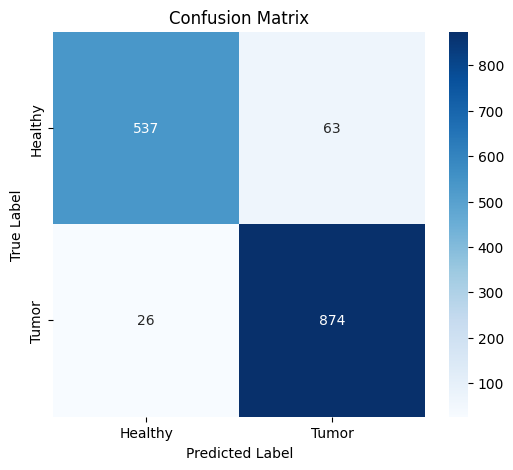

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Names of the classes
class_names = ["Healthy", "Tumor"]

# Start from the beggining of the test set to avoid errors
test_data.reset()

# We calculate the number of steps to make to predict the whole test set
steps = math.ceil(test_data.samples / test_data.batch_size)

# We make predictions for every image of the test set
predictions = best_model.predict(test_data, steps=steps)

# We convert this prections to class indexes (0 = Healthy, 1 = Tumor)
y_pred = np.argmax(predictions, axis=1)

# Labels are 0 and 1 because of the one-hot encoding
y_true = test_data.classes

# Calculation of the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Show the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Prediction to some images of the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


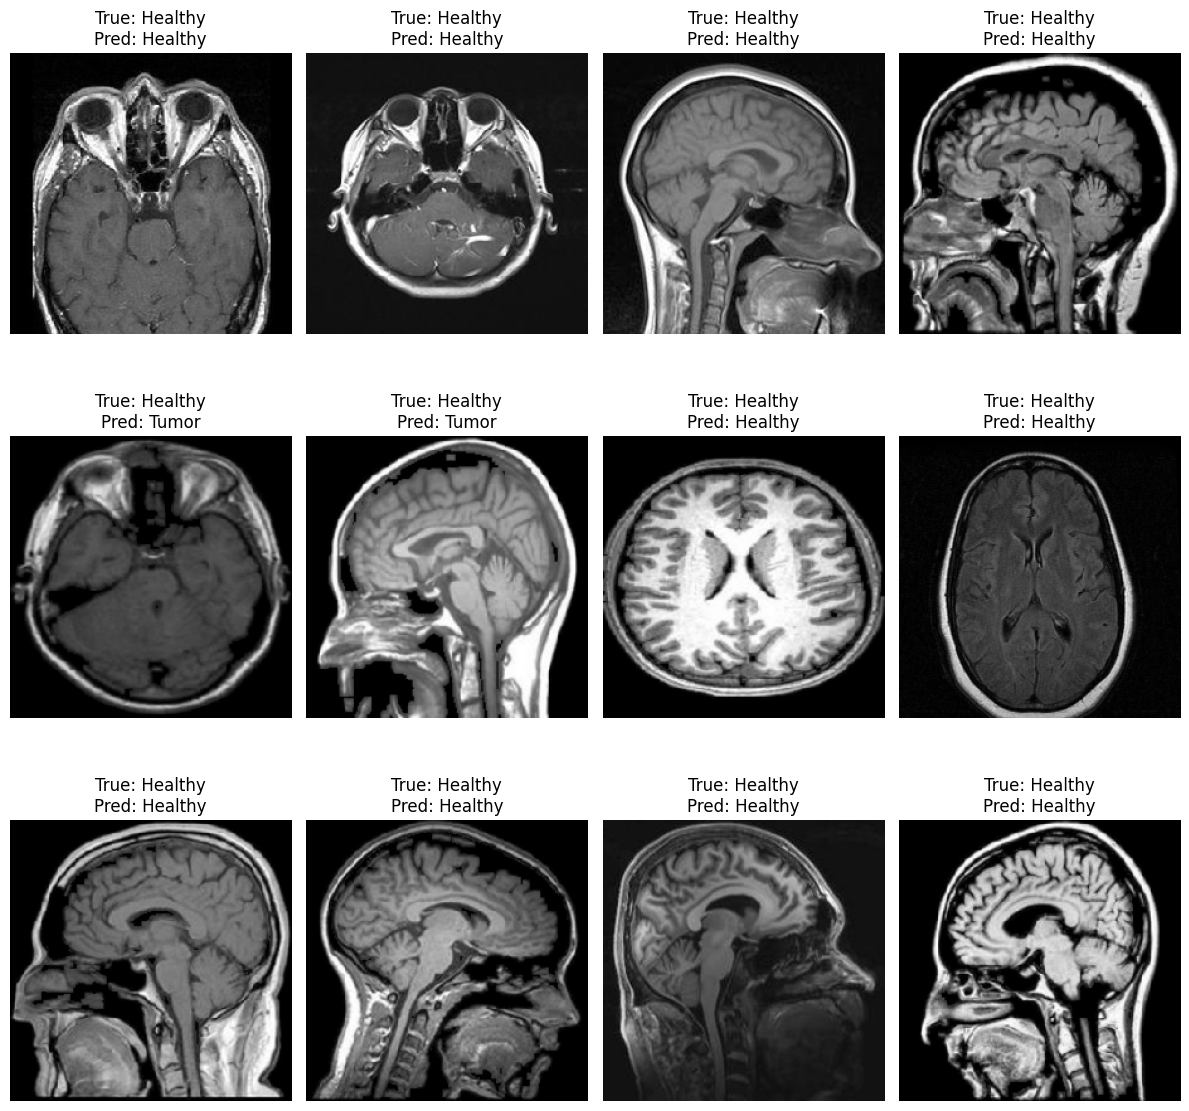

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class_names = ["Healthy", "Tumor"]

# We take a batch of images from the test set
images, labels = next(test_data)

# We obtain the predictions
predictions = model.predict(images)

# We convert the labels and the predictions to the class indexes (0 = Healthy, 1 = Tumor)
true_indices      = np.argmax(labels, axis=1)
predicted_indices = np.argmax(predictions, axis=1)

# How many images to show
num_images_to_show = 12

plt.figure(figsize=(12, 12))
for i in range(num_images_to_show):
    ax = plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns

    # Show the images
    plt.imshow(images[i].astype("float32"))
    plt.axis("off")

    # Real labels and predictions
    true_label = class_names[true_indices[i]]
    pred_label = class_names[predicted_indices[i]]

    # Title for every photo
    plt.title(f"True: {true_label}\nPred: {pred_label}")

plt.tight_layout()
plt.show()